In [1]:
import sys
import os 

!git clone https://github.com/openai/guided-diffusion.git
!pip install -e guided-diffusion

sys.path.append('/kaggle/working/guided-diffusion')

if not os.path.exists("256x256_diffusion_uncond.pt"):
  print("Downloading model weights....")
  !wget https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt

Cloning into 'guided-diffusion'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113 (from 1)
Receiving objects: 100% (113/113), 67.83 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Obtaining file:///kaggle/working/guided-diffusion
  Preparing metadata (setup.py) ... done
  Running setup.py develop for guided-diffusion
--2026-02-19 07:30:36--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 20.60.244.1
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|20.60.244.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2211383297 (2.1G) [application/octet-stream]
Saving to: ‘256x256_diffusion_uncond.pt’

256x256_diffusion_u 100%[===================>]   2.06G  24.4MB/s    in 73s     

2026-02-19 07:31:50 (28.8 MB/s) - ‘256x256_diffusion_unco

In [2]:
!pip install torch torchvision numpy matplotlib opencv-python
import os
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)

def load_diffusion_model(checkpoint_path, device):
    model_config = model_and_diffusion_defaults()
    model_config.update({
        'image_size': 256,
        'num_channels': 256,
        'num_res_blocks': 2,
        'num_heads': 4,
        'num_heads_upsample': -1,
        'attention_resolutions': "32,16,8",
        'dropout': 0.0,
        'diffusion_steps': 1000,
        'noise_schedule': 'linear',
        'use_scale_shift_norm': True,
        'resblock_updown': True,  
        'learn_sigma': True,      
    })

    model, diffusion = create_model_and_diffusion(**model_config)
    model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    model.to(device)
    model.eval()
    return model, diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Loading Diffusion Model... (This may take a moment)")
model, diffusion = load_diffusion_model("256x256_diffusion_uncond.pt", device)
print("Model Loaded!")

Using device: cuda
Loading Diffusion Model... (This may take a moment)
Model Loaded!


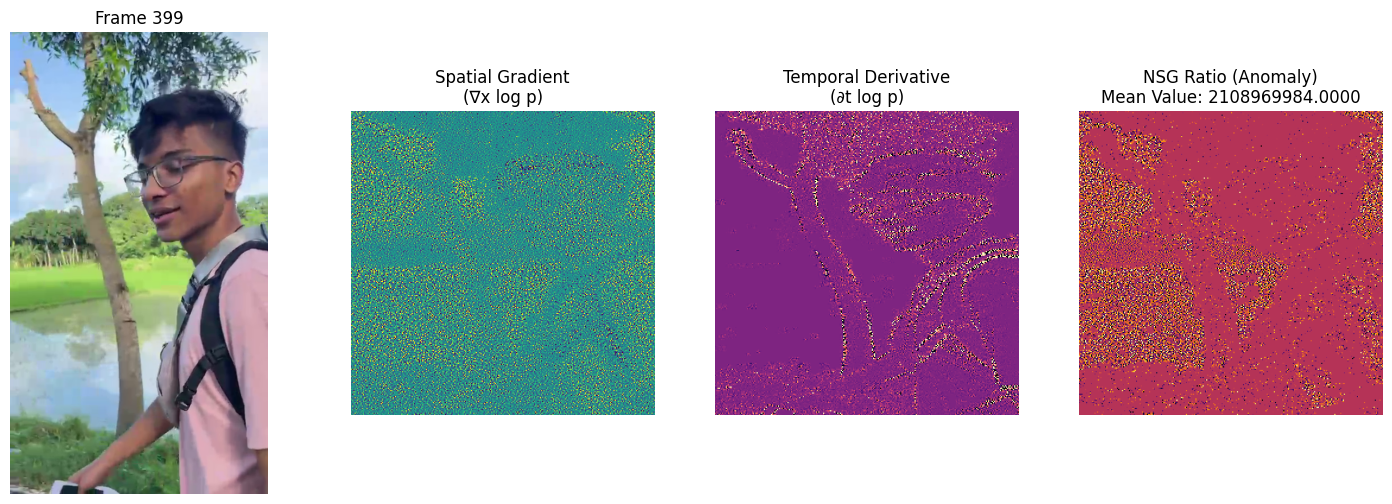

Processing Complete.


In [3]:
def preprocess_cv2_frame(frame, device):
  
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_resized = cv2.resize(frame_rgb, (256, 256), interpolation=cv2.INTER_CUBIC)
    arr = frame_resized.astype(np.float32) / 127.5 - 1
    arr = np.transpose(arr, [2, 0, 1])

    return torch.tensor(arr).unsqueeze(0).to(device)

video_path = '/kaggle/input/datasets/mustakimbinmohsin/girlface/in.mp4' 

if not os.path.exists(video_path):
    print(f"Error: Could not find video at '{video_path}'.")
    print("Please upload a video via 'Add Data' and update the 'video_path' variable.")
else:
    # C. Extract Frames
    def extract_frames(video_path):
        cap = cv2.VideoCapture(video_path)
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        frames = []

        while True:
            success, frame = cap.read()
            if not success:
                break
            frames.append(frame)

        cap.release()
        return frame_rate, len(frames), frames

    print("Extracting frames...")
    frame_rate, frame_count, frames = extract_frames(video_path)
    print(f"Total Frames: {frame_count}, FPS: {frame_rate}")

    t_step = 5
    lambda_param = 1e-10
    max_frames = min(400, frame_count - 1)

    print(f"Processing first {max_frames} frames for visualization...")

    for i in range(max_frames):
        frame_t_raw = frames[i]
        frame_t1_raw = frames[i+1]

        x_t = preprocess_cv2_frame(frame_t_raw, device)
        x_t_next = preprocess_cv2_frame(frame_t1_raw, device)

        t_tensor = torch.tensor([t_step] * x_t.shape[0], device=device)
        noise = torch.randn_like(x_t)
        x_t_noisy = diffusion.q_sample(x_start=x_t, t=t_tensor, noise=noise)

        with torch.no_grad():
            model_output = model(x_t_noisy, t_tensor)

            spatial_gradient = model_output[:, :3, :, :]

        # Formula: ∂t log p(x,t) ≈ - ∇x log p(x,t) * (x_{t+1} - x_t) / Δt
        delta_x = x_t_next - x_t
        temporal_derivative = -1 * (spatial_gradient * delta_x)
        numerator = spatial_gradient
        denominator = -temporal_derivative + lambda_param

        nsg_ratio = numerator / denominator

        nsg_mean_value = nsg_ratio.abs().mean().item()

        # 4. Visualization
        def to_vis(tensor):
            img = tensor.squeeze().mean(dim=0).cpu().numpy()
            v_min, v_max = np.percentile(img, 1), np.percentile(img, 99)
            img = np.clip(img, v_min, v_max)
            return (img - v_min) / (v_max - v_min + 1e-5)

        clear_output(wait=True)

        fig, axes = plt.subplots(1, 4, figsize=(18, 6))

        # Original Frame
        axes[0].imshow(cv2.cvtColor(frame_t_raw, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Frame {i}")
        axes[0].axis("off")

        # Spatial Gradient
        axes[1].imshow(to_vis(spatial_gradient), cmap='viridis')
        axes[1].set_title("Spatial Gradient\n(∇x log p)")
        axes[1].axis("off")

        # Temporal Derivative
        axes[2].imshow(to_vis(temporal_derivative), cmap='magma')
        axes[2].set_title("Temporal Derivative\n(∂t log p)")
        axes[2].axis("off")

        # NSG ratio(Anomaly) Mean Value
        axes[3].imshow(to_vis(nsg_ratio), cmap='inferno')
        axes[3].set_title(f"NSG Ratio (Anomaly)\nMean Value: {nsg_mean_value:.4f}")
        axes[3].axis("off")

        plt.show()
        time.sleep(0.001)

    print("Processing Complete.")